In [1]:
;cd "/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code/"

/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code


In [2]:
]activate learning_ds

In [157]:
include("plotting_utilities.jl")
include("ode_helper.jl")
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random

Loaded diff equations


In [345]:
m = 1.
g = 1.
ℓ = 1.
k = 1.
α = g / ℓ

# vector field for the Elastic Pendulum
# q = x, p = m * ℓ^2 * ẋ
function hamiltonian(p, q)
    return m*g*ℓ * (1 - cos(q)) + p^2 / (2*m*ℓ^2)
end

function pendulum_true_vf(x, ẋ)
    return [ẋ, - g / ℓ * sin(x)]
end



intial_cdts = []
x0 = π/4
ẋ0 = 0.

initial_cdts = [(x0, ẋ0)]
T = 3.
num_samples = 5
x_t1, ẋ_t1 = solve_ode(pendulum_true_vf, [ x0, ẋ0]; verbose=true, tspan = (0., T), length=num_samples)

x0 = .9 * π
ẋ0 = 0.
x_t2 , ẋ_t2 = solve_ode(pendulum_true_vf, [x0, ẋ0]; verbose=true, tspan = (0., T), length=num_samples)
initial_cdts = [initial_cdts..., (x0, ẋ0)]

x_t = [x_t1..., x_t2...]
ẋ_t = [ẋ_t1..., ẋ_t2...]
ẍ_t = -g/ℓ * sin.(x_t)

#ẋ_t = randn(num_samples) * π
#x_t = randn(num_samples) * π
ε = 1e-2 
noise_t = (ε) -> randn(size(x_t, 1)) .* ε
#, x_t = 
size(x_t), size(noise_t(ε))

Solving ODE from x0=[0.785398, 0.0]
size(sol) = (2, 12)
length = 5
Solving ODE from x0=[2.82743, 0.0]
size(sol) = (2, 11)
length = 5


((10,), (10,))

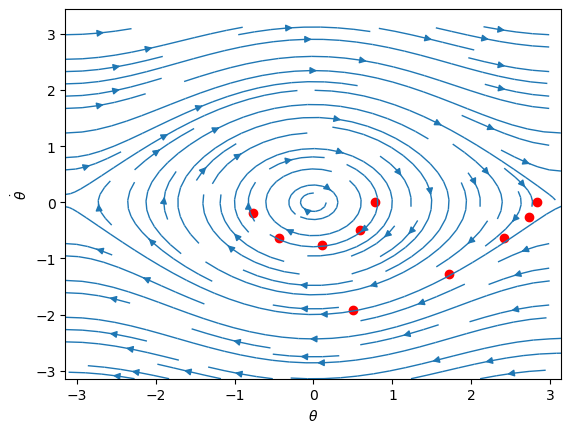

PyObject Text(29.68923611111112, 0.5, '$\\dot\\theta$')

In [347]:
pyplot(size = (400,400))
plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
PyPlot.scatter(x_t, ẋ_t,  color=:red)
PyPlot.xlabel("\$\\theta\$")
PyPlot.ylabel("\$\\dot\\theta\$")

# Learn a polynomial vector field

<img src="polynomial_lagrangian.png">


In [353]:
@polyvar x y

function learn_polynomial_vf(x_t, ẋ_t, ẍ_t; 
        max_deg=6, sym=false, sign_constraints=false) 
    # q = x, p = m * ℓ^2 * ẋ
    monomials = [x^i * y^j for i=0:max_deg for j=0:max_deg if i+j <= max_deg]

    model = SOSModel(with_optimizer(Mosek.Optimizer, LOG=0))
    @variable model c[1:size(monomials, 1)]
    @variable model γ

    f = c' * monomials

    #@constraint H(1, 1)
    if sym
        @constraint model coefficients(f + f(x => -x, y => -y)) .== 0
    end
    if sign_constraints
        S = @set x >= 0
        @constraint model f <= 0 domain = S
        S = @set x <= 0
        @constraint model f >= 0 domain = S
    end
    
    error_term = ẍ_t  - f.(x_t, ẋ_t)
    @constraint model [γ, error_term...] in SecondOrderCone()
    @objective model Min γ
    optimize!(model)
    return value(γ) / size(error_term, 1), [y, value(f)]
end
                
function learn_hamiltonian_vf(x_t, ẋ_t, ẍ_t; 
                        max_deg=6, sym=false, sign_constraints=false)
    # y => ẋ
    monomials = [x^i * y^j for i=0:max_deg for j=0:max_deg if i+j < max_deg && i + j > 0]
    model = SOSModel(with_optimizer(Mosek.Optimizer, LOG=0))
    @variable model c[1:size(monomials, 1)]
    @variable model γ
    H = monomials' * c
    Hx = differentiate(H, x)
    Hy = differentiate(H, y)
    f = [Hy, -Hx]
    error_term = [
        (ẋ_t - f[1].(x_t, ẋ_t))...,
        (ẍ_t - f[2].(x_t, ẋ_t))...
    ]   

    @constraint model [γ, error_term...] in  SecondOrderCone()
    @objective model Min γ
                                    
    if sym
        @constraint model coefficients(H - H(x => x, y => -y)) .== 0
        @constraint model coefficients(H - H(x => -x, y => y)) .== 0
    end
    if sign_constraints
        S = @set x >= 0
        @constraint model f[2] <= 0 domain = S
        S = @set x <= 0
        @constraint model f[2] >= 0 domain = S
    end
    optimize!(model)
    
    return value(γ) / size(error_term, 1), value.(H), value.(f)
end

function compare_learned_vf_to_true_vf(f_value)
    learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
    figure(figsize=(10,5))
    subplot(121)
    learned_vf_plot = plot_vectorfield(learned_vf, (-π, π, 100), (-π, π, 100))
    PyPlot.scatter(x_t, ẋ_t, color=:red)
    PyPlot.xlabel("\$\\theta\$")
    PyPlot.ylabel("\$\\dot\\theta\$")

    subplot(122)
    true_vf_plot = plot_vectorfield(pendulum_true_vf, (-π, π, 100), (-π, π, 100))
    PyPlot.xlabel("\$\\theta\$")
    PyPlot.ylabel("\$\\dot\\theta\$")
end

compare_learned_vf_to_true_vf (generic function with 1 method)

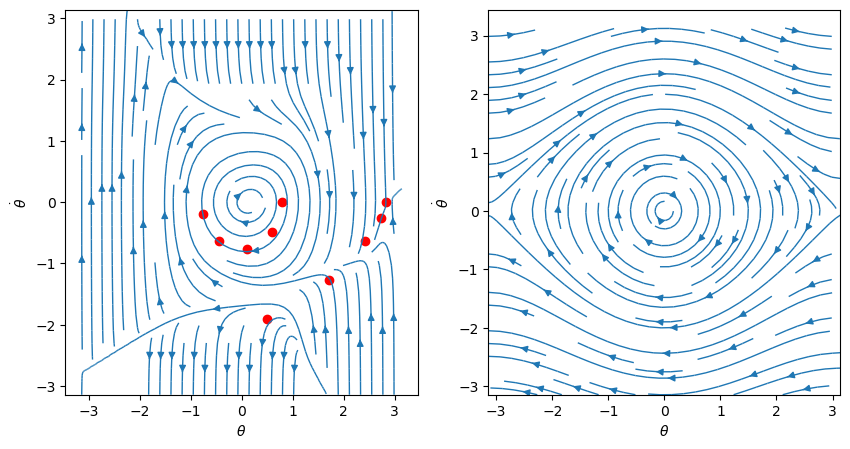

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(6) of matrix 'A'.


6.7467938357318454e-15

In [354]:
ẍ_t = -g/ℓ * sin.(x_t)
ε = .1
Random.seed!(0)
error, f_value = learn_polynomial_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=false,
                                    sign_constraints=false)
compare_learned_vf_to_true_vf(f_value)
error

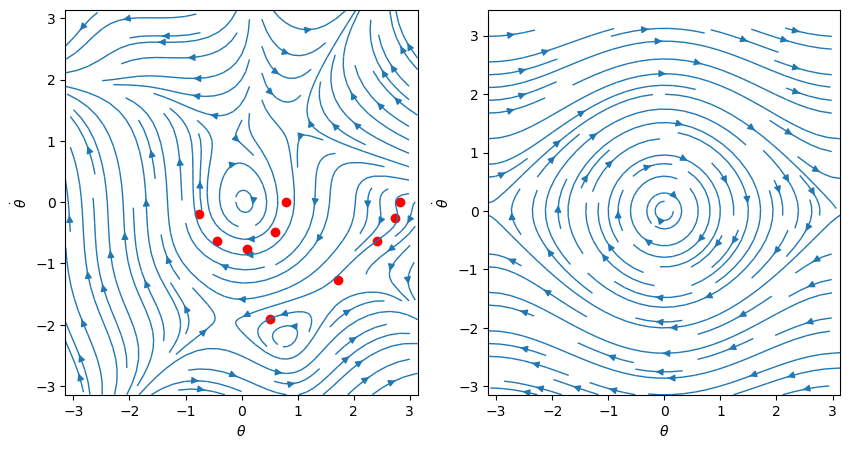

(2.906298123461227e-12, -0.0018503672819668888x⁷ - 0.008473051303722584x⁶y + 0.01584507979857434x⁵y² - 0.055199759453695214x⁴y³ - 0.07897536662564343x³y⁴ + 0.024719389609810054x²y⁵ + 0.031648133782426056xy⁶ + 0.005047022808627579y⁷ + 0.03031798784811612x⁶ + 0.02831547746828638x⁵y - 0.08423535109369877x⁴y² + 0.021335901788399097x³y³ + 0.01163309113913168x²y⁴ + 0.02391099881604674xy⁵ - 0.02450634394466371y⁶ - 0.1312584185237625x⁵ + 0.013461131704914366x⁴y + 0.0031965281644873475x³y² - 0.07226686897090509x²y³ - 0.025628460508980287xy⁴ - 0.013624097220048011y⁵ + 0.136613823614599x⁴ - 0.05256849503165004x³y + 0.11811897743820648x²y² - 0.00010586237197552515xy³ + 0.08901402123135224y⁴ + 0.08525117261821546x³ - 0.085645071687169x²y + 0.025236267895105014xy² - 0.18032200411741572y³ + 0.2850679300030088x² + 0.0651003518331031xy + 0.2246317045006736y² - 0.03075857041107169x - 0.0016411108224118872y)

In [370]:
ε = 0.1
Random.seed!(0)
error, H_value, f_value = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=false,
                                    sign_constraints=false)
compare_learned_vf_to_true_vf(f_value)
error, H_value

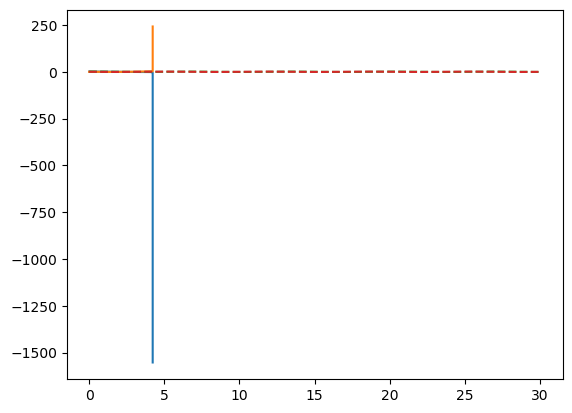

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/bachir/.julia/packages/DiffEqBase/oWErX/src/integrator_interface.jl:162


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd1f569af98>
 PyObject <matplotlib.lines.Line2D object at 0x7fd1f569a588>

In [357]:
learned_vf(xv, yv) = [  f_value[1](x=>xv, y=>yv), f_value[2](x=>xv, y=>yv) ]
poly_vf(u, p, t) = learned_vf(u...)
true_vf(u, p, t) = pendulum_true_vf(u...)

T_eval = 10*T
u₀ = [π/3, 0.]

prob = ODEProblem(true_vf, u₀, (0., T_eval))
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)


prob = ODEProblem(poly_vf, u₀, (0., T_eval))
poly_sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

pyplot()
PyPlot.figure()
PyPlot.plot(poly_sol.t, poly_sol.u)
PyPlot.plot(sol.t, sol.u, ls="dashed")

#Plots.plot!(learned_sol, vars=(7, 8), color=:red)


# Export data

In [358]:
# export real solution
using CSV
using DataFrames

In [374]:
function export_vf(vf, name;
        T_eval = 2*T, dt = .1, initial_cdts=initial_cdts)   
    ode_vf(u, p, t) = vf(u...)
    X_t = []
    t = collect(0:dt:T_eval)

    for u₀ in initial_cdts
        prob = ODEProblem(ode_vf, [u₀...], (0., T_eval))
        sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
        X_ti = hcat(sol.(t)...)
        X_t = [X_t..., X_ti]
        
    end
    df = DataFrame(t=t, theta1=X_t[1][1,:], theta_dot1=X_t[1][2,:],
                   theta2=X_t[2][1,:], theta_dot2=X_t[2][2,:])
    CSV.write("pendulum/trajectory_simple_pendulum_$name.csv", df)
    
    # export vf
    PyPlot.figure()
    my_streamplot, segments, arrows = latex_vectorfield(vf, 
        (-π, π, 100), (-π, π, 100))
    CSV.write("pendulum/segments_$name.csv", segments)
    CSV.write("pendulum/arrows_$name.csv", arrows)
    
    
end

function export_solution(f_as_poly, opt_value, name; H_as_poly=0)
    open("pendulum/polynomial_solution_$name.poly", "w") do f
        print()
        for i=1:2
            write(f, latexstring(f_as_poly[i]))
            write(f, "\n")
        end
        write(f, "opt_value = " * string(opt_value))
        write(f, "\n")
        write(f, "H_as_poly = " * string(H_as_poly))
        write(f, "\n")
    end
end



export_solution (generic function with 1 method)

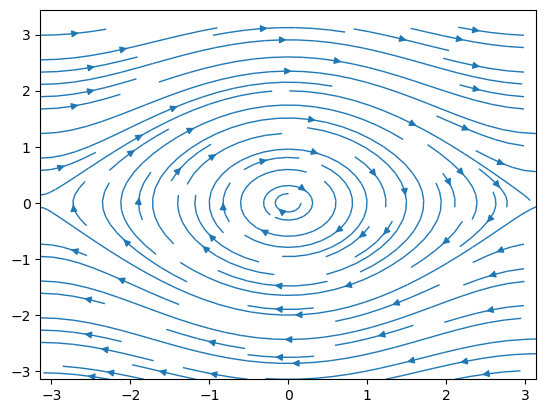

"pendulum/arrows_true_vf.csv"

In [387]:
name = "true_vf"
export_vf(pendulum_true_vf, name; 
    T_eval = 10*T, dt = .1, initial_cdts=initial_cdts)   


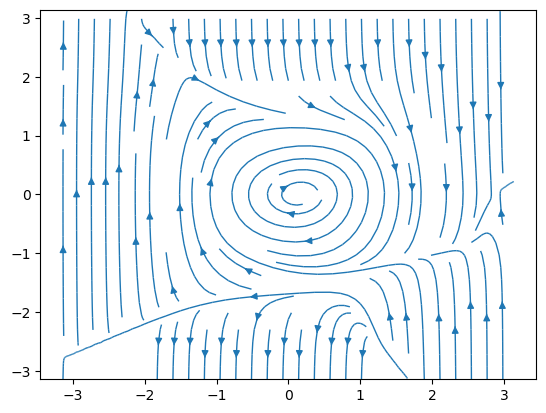

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(6) of matrix 'A'.


1

In [375]:
# no side info
Random.seed!(0)
name = "poly_vf"
opt_value, f_as_poly = learn_polynomial_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=false,
                                    sign_constraints=false)
vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = 10*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name)

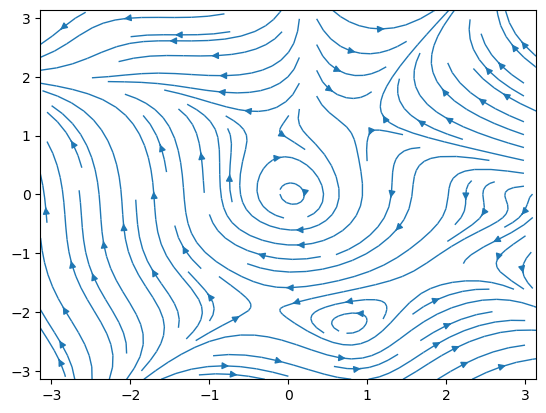

1

In [377]:
# hamiltonian
Random.seed!(0)
name = "hamiltonian_vf"
opt_value, H_as_poly, f_as_poly = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=false,
                                    sign_constraints=false)

vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), 
                f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = .1*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name; H_as_poly=H_as_poly)

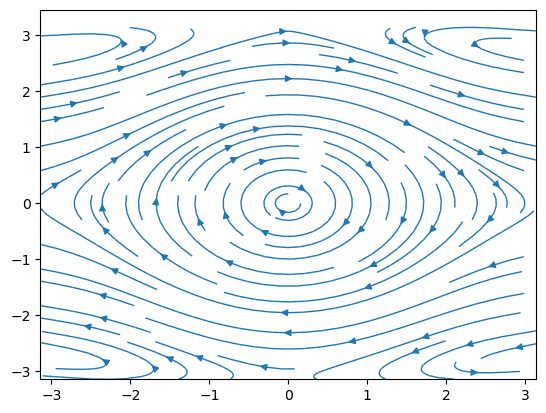

1

In [378]:
# hamiltonian + sym
Random.seed!(0)
name = "hamiltonian_sym_vf"
opt_value, H_as_poly, f_as_poly = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=true,
                                    sign_constraints=false)

vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), 
                f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = .1*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name; H_as_poly=H_as_poly)

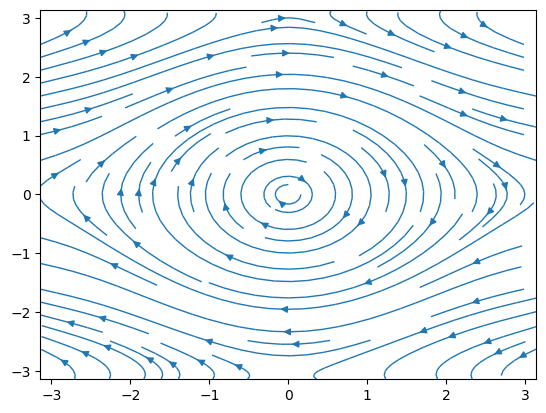

1

In [392]:
# hamiltonian + sym + pos
Random.seed!(0)
name = "hamiltonian_sym_pos_vf"
opt_value, H_as_poly, f_as_poly = learn_hamiltonian_vf(x_t.+ noise_t(ε), 
                                      ẋ_t.+ noise_t(ε), 
                                      ẍ_t.+ noise_t(ε),
                                    max_deg=8,
                                    sym=true,
                                    sign_constraints=true)

vf(xv, yv) = [  f_as_poly[1](x=>xv, y=>yv), 
                f_as_poly[2](x=>xv, y=>yv) ]

export_vf(vf, name;T_eval = 10*T, dt = .1, initial_cdts=initial_cdts)   
export_solution(f_as_poly, opt_value, name; H_as_poly=H_as_poly)

In [386]:
;cp pendulum/*csv pendulum/*poly* ~/Dropbox/AAA_Bachir/Learning_with_side_information/Drafts/Learning_with_side_information_v1/data/pendulum/

cp: cannot stat 'pendulum/*csv': No such file or directory
cp: cannot stat 'pendulum/*poly*': No such file or directory


In [391]:
;ls pendulum

2-body-problem-hamiltonian.ipynb
arrows_hamiltonian_sym_pos_vf.csv
arrows_hamiltonian_sym_vf.csv
arrows_hamiltonian_vf.csv
arrows_poly_vf.csv
arrows_true_vf.csv
lagrangian.htm
mass-spring-hamiltonian.ipynb
pendulum.ipynb
pendulum_ode.m
physical_system.m
polynomial_lagrangian.png
polynomial_solution_hamiltonian_sym_pos_vf.poly
polynomial_solution_hamiltonian_sym_vf.poly
polynomial_solution_hamiltonian_vf.poly
polynomial_solution_poly_vf.poly
segments_hamiltonian_sym_pos_vf.csv
segments_hamiltonian_sym_vf.csv
segments_hamiltonian_vf.csv
segments_poly_vf.csv
segments_true_vf.csv
simple-pendulum-hamiltonian.ipynb
simple_pendulum_lagrangian.ipynb
simple-pendulum-poly-vs-hamiltonian-vf.ipynb
trajectory_simple_pendulum_hamiltonian_sym_pos_vf.csv
trajectory_simple_pendulum_hamiltonian_sym_vf.csv
trajectory_simple_pendulum_hamiltonian_vf.csv
trajectory_simple_pendulum_poly_vf.csv
trajectory_simple_pendulum_true_vf.csv
vectorfield_to_latex.ipynb
